# DDE model with gradients

DDEs require models that produces output beased on its gradients wrt. to the input. So we make our own model that transfers the output of a neural network by computing its gradients.

In [1]:
from tensorflow import keras

class DDE(keras.Model):
    def __init__(self, net_model, noise_std):
        super(DDE, self).__init__()
        self.net_model = net_model
        self.noise_std = noise_std

    def compile(self, optimizer):
        super(DDE, self).compile()
        self.optimizer = optimizer

    def call(self, noisy_input):
        
        # 1. Get the DDE output for input noisy images.
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(noisy_input)
            log_prob = self.net_model(noisy_input, training=True)
            
        # 2. Calculate the gradients w.r.t to the input.
        grad_log_prob = gp_tape.gradient(log_prob, [noisy_input])[0]
                
        return log_prob, grad_log_prob
    
    def gaussian_noise_layer(self, input_layer):
        noise = tf.random.normal(shape=tf.shape(input_layer), mean=0.0, stddev=self.noise_std, dtype=tf.float32) 
        noisy = input_layer + noise
        noise_gt = -noise/self.noise_std/self.noise_std
        return noisy, noise_gt

    def generate(self, batch):
        noisy, noise_gt = self.gaussian_noise_layer(batch)
        log_probs, noise_estim = self.call(noisy)
        denoised = noisy+noise_estim*self.noise_std*self.noise_std
        return log_probs, noisy, denoised

    # Calculate model gradients for optimization and take an optimizatino step.
    # TF will implicitly include the loss gradients by going through the noise-estimation branch.
    def train_step(self, input):
        batch = input

        noisy_input, noise_gt = self.gaussian_noise_layer(batch)
        
        # Get the batch size
        batch_size = tf.shape(batch)[0]

        with tf.GradientTape() as tape:
            _, noise_estim = self.call(noisy_input)
            # Calculate the noise estimation penalty based on MSE (Eq. 5 in paper)
            loss = tf.keras.losses.mean_squared_error(noise_estim, noise_gt)

        # Get the gradients w.r.t the generator loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}

In [2]:
# Generate neral network model for DDE. We need to satisfy two cnoditions:
# 1. The output of the network is a scalar value: we apply this by setting the number of neurons in the last layer to 1
# 2. The network is twice-differentiable: we achive this by using TanH activations

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf

kernel_initializer = 'he_normal'

def generate_net_model(pretrained_weights = None, input_size=(2), ch=32):
    inputs = Input(input_size)
    layer1 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(inputs)
    #layer1 = tf.keras.layers.Softplus()(layer1)
    layer2 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer1)
    #layer2 = tf.keras.layers.LeakyReLU()(layer2)
    layer3 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer2)
    #layer3 = tf.keras.layers.LeakyReLU()(layer3)
    log_prob = Dense(1, activation='linear', use_bias=False, kernel_initializer=kernel_initializer)(layer3)
    model = Model(inputs, log_prob)
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


In [3]:
# Select GPUs and generate the network model
import tensorflow as tf

gpu_to_restrict = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_to_restrict], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_to_restrict], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
        
net_model = generate_net_model(pretrained_weights = None)

2 Physical GPUs, 1 Logical GPU
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 32        
Total params: 2,240
Trainable params: 2,240
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Creat our DDE model and pass it the neural network and its optimizer

dde = DDE(net_model, noise_std = 0.1)
optimizer = tf.optimizers.Adam(lr = 1e-3)
dde.compile(optimizer=optimizer)#, loss = ['mse', None], metrics = ['mse', None])


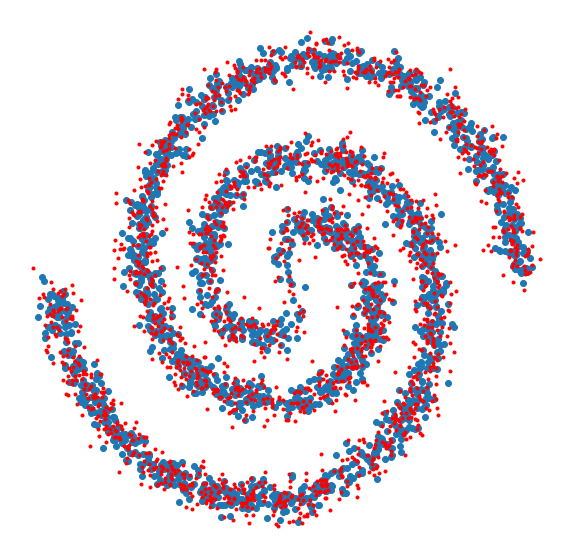

In [5]:
# Data generator implementation for 2D toy distributions: 8gaussians, 2spirals, checkerboard, rings

from tensorflow.keras.utils import Sequence
from utils import sample_2d_data
import numpy as np

class DataGenerator(Sequence):
    def __init__(self, num_total_samples=1e4, dataset='2spirals', batch_size=512):
        'Initialization'
        self.batch_size = batch_size
        self.num_total_samples = num_total_samples
        self.data = sample_2d_data(dataset, int(self.num_total_samples))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.num_total_samples // self.batch_size)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise ValueError("idx must be an integer.")
        if not 0 <= idx < self.__len__():
            raise ValueError("idx is out of bounds.")

        # extract the current batch from dataset
        batch = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # output niosy and the ground truth noise (scaled by its variance, Eq. 5 in paper)
        return batch

# This is a helper function to generate the denoised results from noisy input and noise estimates
def get_denoised(input_noisy, noise_estimate, sigma):
    return input_noisy+noise_estimate*sigma*sigma


# Visualise some samples
import matplotlib.pyplot as plt
generator = DataGenerator(batch_size=2048)
batch_gt = generator.__getitem__(0)
_, batch_noisy, batch_denoised = dde.generate(batch_gt)
plt.figure(figsize=(10,10))
plt.plot(batch_gt[:,0], batch_gt[:,1], 'o')
plt.plot(batch_noisy[:,0], batch_noisy[:,1], '.r')
_ = plt.axis("off")


In [6]:
# Helper functions and callbacks for visualization and writing of the resulting density

def get_density_map(wdt = 4, granularity = 10):
    x_range = np.array(range(-wdt*granularity, wdt*granularity))/granularity
    y_range = np.array(range(wdt*granularity, -wdt*granularity, -1))/granularity
    
    X, Y = np.meshgrid(x_range, y_range)
    shape = X.shape
    X = X.reshape(np.prod(shape), order='C')
    Y = Y.reshape(np.prod(shape), order='C')
    input_data = np.array([X,Y]).transpose()

    log_prob_data = dde(input_data)[0].numpy()
    log_prob_data -= log_prob_data.max()
    prob_data = np.exp(log_prob_data[:,0])
    prob_data = prob_data.reshape(shape, order='C')
    return prob_data
        
def get_vector_field(wdt = 4, granularity = 10):
    x_range = np.array(range(-wdt*granularity, wdt*granularity))/granularity
    y_range = np.array(range(wdt*granularity, -wdt*granularity, -1))/granularity
    
    X, Y = np.meshgrid(x_range, y_range)
    shape = X.shape
    X = X.reshape(np.prod(shape), order='C')
    Y = Y.reshape(np.prod(shape), order='C')
    input_data = np.array([X,Y]).transpose()

    logp, grads = dde(input_data)
    logp = logp.numpy()
    logp = logp[:,0].reshape(shape, order='C')
    grads = grads.numpy()
    d_X = grads[:,0].reshape(shape, order='C')
    d_Y = grads[:,1].reshape(shape, order='C')
    return x_range, y_range, d_X, d_Y, logp

def show_vectorfield_plot(x, y, d_x, d_y, logp):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.streamplot(x, y, d_x, d_y, linewidth=1, color=logp, cmap=plt.cm.inferno,
          density=2, arrowstyle='->', arrowsize=1.5)
    ax.set_axis_off()

def show_density_plot(logp):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(np.exp(logp-logp.max()))
    ax.set_axis_off()

    
from tensorflow import keras
import matplotlib.pyplot as plt
class DensityPlotCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%100 != 0:
            return
        
        logp = get_density_map()
        show_density_plot(logp)
        plt.show()
        
class DensityPlotWriterCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 10000 and epoch%1000 != 0:
            return
        if 300< epoch < 10000 and epoch%100 != 0:
            return
        epoch_id = str(epoch).zfill(6)
        
        plt.ion()
        x, y, d_x, d_y, logp = get_vector_field()        
        
        show_vectorfield_plot(x, y, d_x, d_y, logp)
        plt.savefig('vec_' + epoch_id)
        
        show_density_plot(logp)
        plt.savefig('den_' + epoch_id)
        plt.ioff()

In [ ]:
dde.fit(
    x=generator,
    epochs = 1000,
    callbacks=[DensityPlotCallback()])


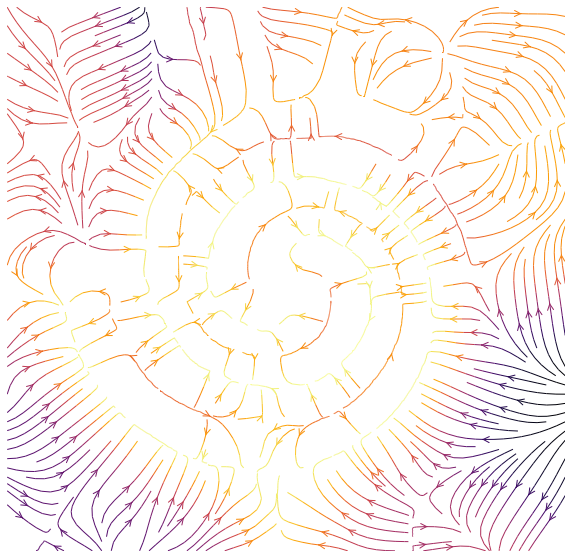

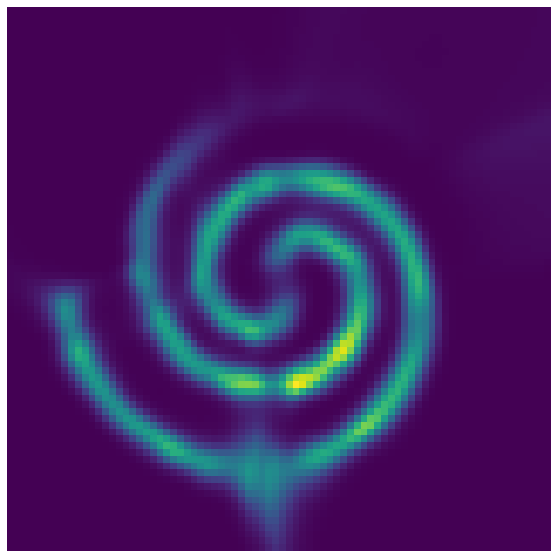

In [8]:
x, y, d_x, d_y, logp = get_vector_field()        

show_vectorfield_plot(x, y, d_x, d_y, logp)

show_density_plot(logp)